In [1]:
!pip install tidy3d
import tidy3d.web as web
web.configure("wclpAIGF4JlvJlABZs9BOY3yg53fsAAd54VzLiVcCFPu7pFC")

Configured successfully.


In [2]:
!pip install gdstk

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.resonance import ResonanceFinder

import gdstk

In [4]:
lambda_min = 0.8
lambda_max = 1.1

monitor_lambda = np.linspace(lambda_min, lambda_max, 101)
monitor_freq = td.constants.C_0/monitor_lambda

automesh_per_wvl = 20
#dl = 0.02 # uniform sampling mesh size

sim_size = Lx, Ly, Lz = (12, 12, 4)
offset_monitor = 1 # monitor position in the vertical direction

vacuum = td.Medium(permittivity = 1, name = 'vacuum')
GaAs_permittivity = 3.55**2
GaAs = td.Medium(permittivity = GaAs_permittivity, name = 'GaAs')

freq0 = 302.675e12 # taken from the Lumerical file supplied by Dr. Dima
fwidth = 144.131e12 #
freq0 = 302.675e12 # taken from the Lumerical file supplied by Dr. Dima

t_start = 10/fwidth  # from inspection
t_stop = 10e-12

slab_side_length = 20
slab_height = 0.15

In [5]:
slab = td.Structure(
    geometry = td.Box(
        center = (0, 0, 0),
        size = (slab_side_length, slab_side_length, slab_height)
    ),
    medium = GaAs,
    name = 'GaAs slab'
)

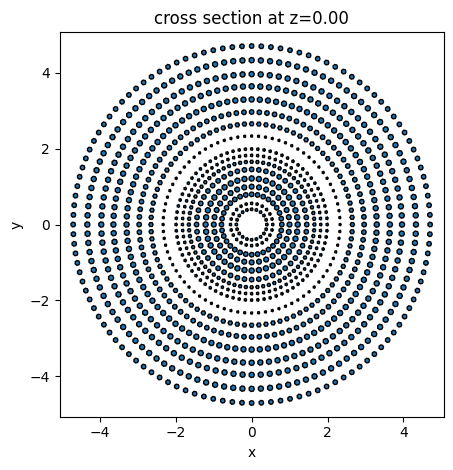

In [6]:

# Create GDS library and cell
lib = gdstk.Library()
cell = lib.new_cell("HOLEY_GAAS_UNIFORM")

# Hole parameters (radius in µm, diameter in nm, number of holes originally in one quadrant)
hole_layers = [
    (0.402, 77, 5),
    (0.557, 72, 6),
    (0.795, 126, 8),
    (0.998, 135, 8),
    (1.214, 144, 10),
    (1.452, 126, 12),
    (1.654, 90, 17),
    (1.823, 72, 18),
    (1.992, 72, 19),
    (2.332, 63, 20),
    (2.654, 117, 22),
    (2.965, 126, 23),
    (3.297, 144, 24),
    (3.643, 144, 25),
    (3.963, 144, 26),
    (4.331, 144, 28),
    (4.704, 126, 29),
]

# Generate uniform holes over 360 degrees
for radius, diameter_nm, count_quadrant in hole_layers:
    diameter_um = diameter_nm / 1000.0
    total_holes = count_quadrant * 4  # distribute uniformly over 360°
    angles = np.linspace(0, 2 * np.pi, total_holes, endpoint=False)
    for angle in angles:
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        hole = gdstk.ellipse((x, y), diameter_um / 2, layer=1)
        cell.add(hole)


holes = td.Geometry.from_gds(
        cell, gds_layer=1, axis=2, slab_bounds=(-slab_height/2, slab_height/2)
    )

holes.plot(z=0)
plt.show()

In [7]:
mat_etch = td.Medium(permittivity = 1, name = 'air')
etch = td.Structure(
    geometry = holes,
    medium = mat_etch,
    name = 'etch'
)

In [8]:
dipole_source = td.PointDipole(
    center = (0, 0, 0),
    source_time = td.GaussianPulse(
        freq0 = freq0,
        fwidth = fwidth),
    polarization = 'Ex',
    name = 'dipole_source'
)

In [9]:
time_monitor_1 = td.FieldTimeMonitor(
    name = 'time_monitor_1',
    size = [0, 0, 0],
    center = [0.1, 0.1, 0],
    start = t_start
)

time_monitor_2 = td.FieldTimeMonitor(
    name = 'time_monitor_2',
    size = [0, 0, 0],
    center = [0.1, 0.2, 0],
    start = t_start
)

time_monitor_3 = td.FieldTimeMonitor(
    name = 'time_monitor_3',
    size = [0, 0, 0],
    center = [0.2, 0.2, 0],
    start = t_start
)

time_monitor_4 = td.FieldTimeMonitor(
    name = 'time_monitor_4',
    size = [0, 0, 0],
    center = [0.2, 0.1, 0],
    start = t_start
)

time_monitors = [time_monitor_1, time_monitor_2, time_monitor_3, time_monitor_4]
     


In [11]:
far_field_monitor = td.FieldProjectionAngleMonitor(
    center = (0, 0, offset_monitor),
    size = (td.inf, td.inf, 0),
    name = 'far_field_monitor',
    freqs = monitor_freq,
    normal_dir = '+',
    phi = np.linspace(0, 2 * np.pi, 181),
    theta = np.linspace(0, np.pi, 91)
)

In [12]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.auto(
        wavelength = (lambda_min + lambda_max)/2,
        min_steps_per_wvl = automesh_per_wvl
        ),
    run_time = t_stop,
    sources = [dipole_source],
    monitors = time_monitors + [far_field_monitor],
    structures = [slab, etch],
    medium = vacuum,
    shutoff = 1e-7,
    symmetry = [-1, 1, 0]
)

17:16:29 Eastern Daylight Time WARNING: Field projection monitor                
                               'far_field_monitor' has observation points set up
                               such that the monitor is projecting backwards    
                               with respect to its 'normal_dir'. If this was not
                               intentional, please take a look at the           
                               documentation associated with this type of       
                               projection monitor to check how the observation  
                               point coordinate system is defined.              

In [13]:

sim.plot_3d()

In [14]:
task_id = web.upload(sim, task_name = 'CavityWithHoles_1')
     

17:16:45 Eastern Daylight Time Created task 'CavityWithHoles_1' with task_id    
                               'fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=987980;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=368887;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\taskId]8;;\
                               ]8;id=987980;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\=]8;;\]8;id=410657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\fdve]8;;\]8;id=987980;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16']8;;\.

                               Task folder: ]8;id=872387;https://tidy3d.simulation.cloud/folders/folder-011dcacc-1116-40e1-81d8-7befbba73e83\'default']8;;\.

Output()

17:16:48 Eastern Daylight Time Maximum FlexCredit cost: 4.378. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

In [15]:
web.estimate_cost(task_id)

17:16:52 Eastern Daylight Time Maximum FlexCredit cost: 4.378. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

4.37762288767967

In [16]:
web.start(task_id)
web.monitor(task_id, verbose = True)

17:16:55 Eastern Daylight Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

17:17:06 Eastern Daylight Time starting up solver

                               running solver

Output()

Output()

17:33:44 Eastern Daylight Time status = postprocess

17:33:51 Eastern Daylight Time status = success

17:33:53 Eastern Daylight Time View simulation result at                        
                               ]8;id=498891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=2989;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\taskId]8;;\
                               ]8;id=498891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\=]8;;\]8;id=629333;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\fdve]8;;\]8;id=498891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16\-2d9d5ba2-2ccf-42e5-8a8e-876408fbcd16']8;;\.

In [17]:
web.real_cost(task_id)

17:47:14 Eastern Daylight Time Billed flex credit cost: 4.378.

                               Note: the task cost pro-rated due to early       
                               shutoff was below the minimum threshold, due to  
                               fast shutoff. Decreasing the simulation          
                               'run_time' should decrease the estimated, and    
                               correspondingly the billed cost of such tasks.

4.37762288767967

In [18]:
sim_data = web.load(task_id, path='data/CavityWithHoles_1.hdf5')
print(sim_data.log)

Output()

17:47:42 Eastern Daylight Time loading simulation from                          
                               data/CavityWithHoles_1.hdf5

                               WARNING: Field projection monitor                
                               'far_field_monitor' has observation points set up
                               such that the monitor is projecting backwards    
                               with respect to its 'normal_dir'. If this was not
                               intentional, please take a look at the           
                               documentation associated with this type of       
                               projection monitor to check how the observation  
                               point coordinate system is defined.              

                               WARNING: Simulation final field decay value of   
                               5.74e-05 is greater than the simulation shutoff  
                               threshold of 1e-07. Consider running the         
                               simulation again with a larger 'run_time'        
                               duration for more accurate results.              

17:47:43 Eastern Daylight Time WARNING: Warning messages were found in the      
                               solver log. For more information, check          
                               'SimulationData.log' or use                      
                               'web.download_log(task_id)'.                     

[21:17:00] WARNING: Field projection monitor 'far_field_monitor' has observation
           points set up such that the monitor is projecting backwards with     
           respect to its 'normal_dir'. If this was not intentional, please take
           a look at the documentation associated with this type of projection  
           monitor to check how the observation point coordinate system is      
           defined.                                                             
[21:17:01] USER: Simulation domain Nx, Ny, Nz: [924, 924, 122]                  
           USER: Applied symmetries: (-1, 1, 0)                                 
           USER: Number of computational grid points: 2.6697e+07.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(

In [19]:

sim_data = td.SimulationData.from_file(fname = 'data/CavityWithHoles_1.hdf5')

17:47:53 Eastern Daylight Time WARNING: Field projection monitor                
                               'far_field_monitor' has observation points set up
                               such that the monitor is projecting backwards    
                               with respect to its 'normal_dir'. If this was not
                               intentional, please take a look at the           
                               documentation associated with this type of       
                               projection monitor to check how the observation  
                               point coordinate system is defined.              

In [20]:
resonance_finder = ResonanceFinder(freq_window=(monitor_freq[-1], monitor_freq[0]))
resonance_data = resonance_finder.run(signals=sim_data.data)
resonance_data.to_dataframe()

,decay,Q,amplitude,phase,error
freq,,,,,
3.091381e+14,3.540328e+11,2743.208841,0.391102,-2.267157,0.023033
3.119418e+14,1.732656e+11,5656.022571,10.373436,-2.142792,0.002330
3.128127e+14,1.952000e+11,5034.477172,19.323405,0.580209,0.000955
3.210190e+14,2.776540e+11,3632.257384,343.577127,0.541365,0.000403
3.614667e+14,6.530325e+11,1738.934841,5.852618,-0.292285,0.007798
3.667641e+14,1.908731e+12,603.659424,195.460762,0.811790,0.002065
3.673527e+14,1.803838e+12,639.787162,80.251522,-2.617459,0.003869
3.695900e+14,2.085150e+12,556.843094,31.927008,-3.131307,0.004467
3.758254e+14,2.066440e+12,571.364379,59.590018,-2.227976,0.003490


C:\Users\adas24\AppData\Local\Temp\ipykernel_16748\3745431529.py:33: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ex = td.constants.C_0 / freqs_Ex
C:\Users\adas24\AppData\Local\Temp\ipykernel_16748\3745431529.py:34: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ey = td.constants.C_0 / freqs_Ey
C:\Users\adas24\AppData\Local\Temp\ipykernel_16748\3745431529.py:35: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ez = td.constants.C_0 / freqs_Ez


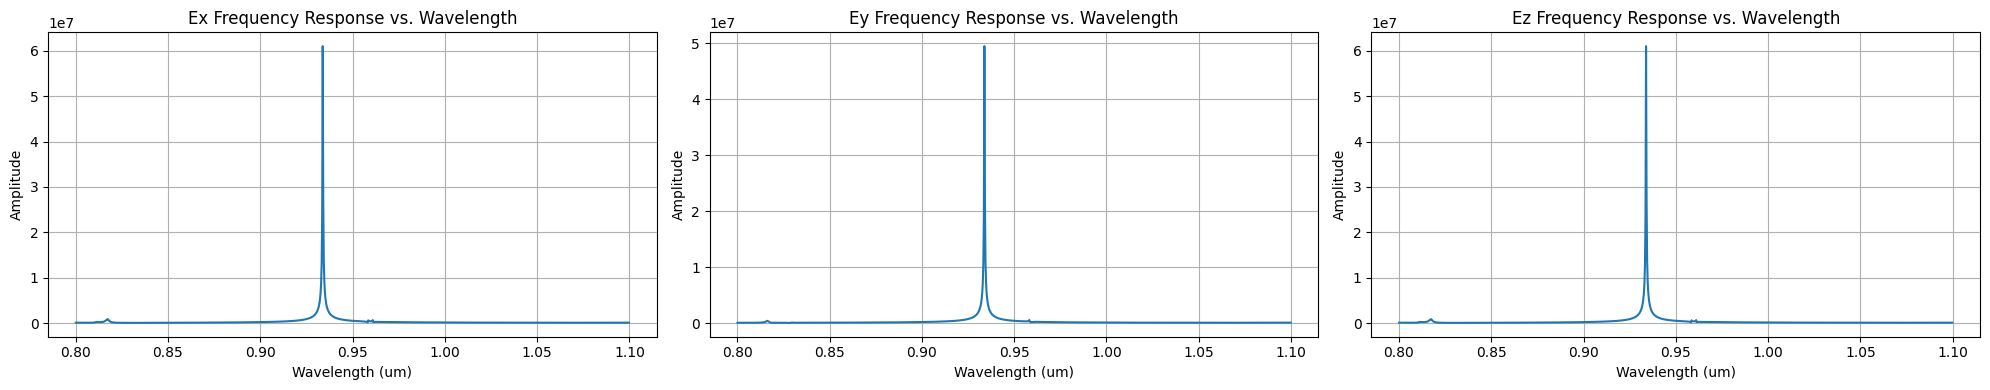

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20, 4))

time_monitor_names = [monitor.name for monitor in time_monitors]

time_response_Ex = np.zeros_like(sim_data["time_monitor_1"].Ex.squeeze())
time_response_Ey = np.zeros_like(sim_data["time_monitor_1"].Ey.squeeze())
time_response_Ez = np.zeros_like(sim_data["time_monitor_1"].Ez.squeeze())

for monitor_name in time_monitor_names:
    time_response_Ex += sim_data[monitor_name].Ex.squeeze()
    time_response_Ey += sim_data[monitor_name].Ey.squeeze()
    time_response_Ez += sim_data[monitor_name].Ez.squeeze()

time_response_Ex /= len(time_monitor_names)
time_response_Ey /= len(time_monitor_names)
time_response_Ez /= len(time_monitor_names)


# Perform FFT and get the frequency response
freq_response_Ex = np.abs(np.fft.fft(time_response_Ex))
freq_response_Ey = np.abs(np.fft.fft(time_response_Ey))
freq_response_Ez = np.abs(np.fft.fft(time_response_Ez))

# Calculate the frequency values
freqs_Ex = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ex))
freqs_Ey = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ey))
freqs_Ez = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ez))

# Calculate the corresponding wavelengths
wavelengths_Ex = td.constants.C_0 / freqs_Ex
wavelengths_Ey = td.constants.C_0 / freqs_Ey
wavelengths_Ez = td.constants.C_0 / freqs_Ez

# Select the indices within the monitor frequency range
plot_inds_Ex = np.where((monitor_freq[-1] < freqs_Ex) & (freqs_Ex < monitor_freq[0]))
plot_inds_Ey = np.where((monitor_freq[-1] < freqs_Ey) & (freqs_Ey < monitor_freq[0]))
plot_inds_Ez = np.where((monitor_freq[-1] < freqs_Ez) & (freqs_Ez < monitor_freq[0]))

# Plot the frequency response with respect to wavelength
ax[0].plot(wavelengths_Ex[plot_inds_Ex], freq_response_Ex[plot_inds_Ex])
ax[0].set_xlabel("Wavelength (um)")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Ex Frequency Response vs. Wavelength")
ax[0].grid(True)

ax[1].plot(wavelengths_Ey[plot_inds_Ey], freq_response_Ey[plot_inds_Ey])
ax[1].set_xlabel("Wavelength (um)")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Ey Frequency Response vs. Wavelength")
ax[1].grid(True)

ax[2].plot(wavelengths_Ex[plot_inds_Ez], freq_response_Ex[plot_inds_Ez])
ax[2].set_xlabel("Wavelength (um)")
ax[2].set_ylabel("Amplitude")
ax[2].set_title("Ez Frequency Response vs. Wavelength")
ax[2].grid(True)

# Reverse the x-axis to show decreasing wavelength (optional)
#ax1.set_xlim(ax1.get_xlim()[::-1])

plt.show()
#plt.savefig('Resonance_data')
     
#plt.savefig('Resonance_data')
     

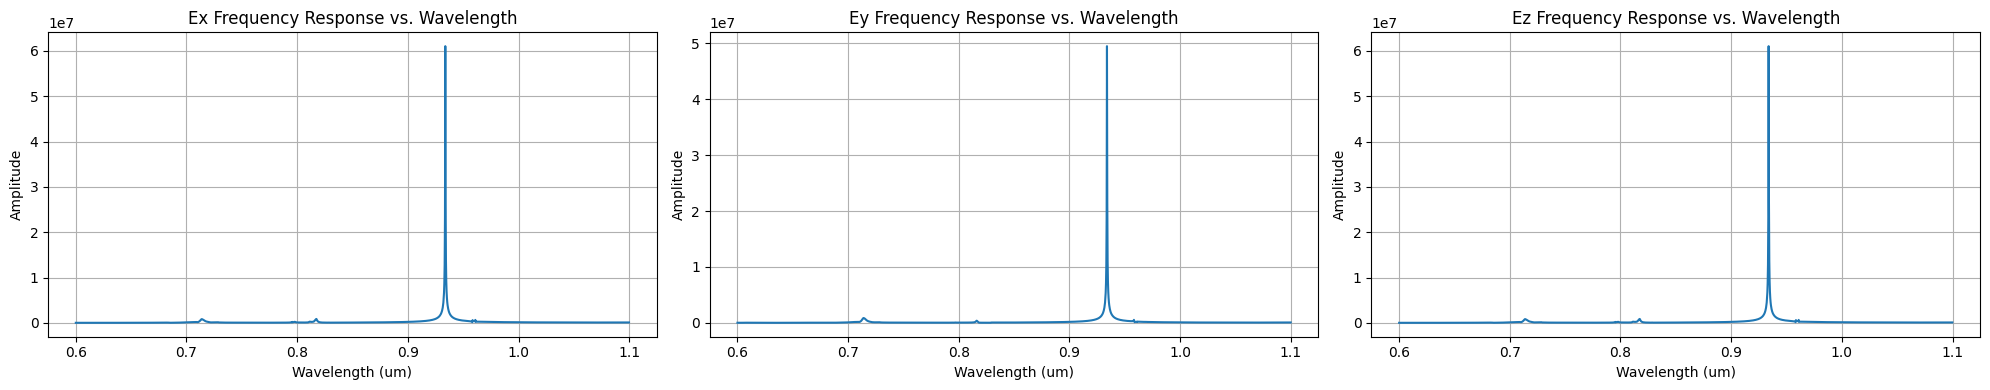

In [22]:
wavelength_short = np.array([0.6, 1.1])
freq_short = td.constants.C_0 / wavelength_short

plot_inds_Ex_short = np.where((freq_short[-1] < freqs_Ex) & (freqs_Ex < freq_short[0]))
plot_inds_Ey_short = np.where((freq_short[-1] < freqs_Ey) & (freqs_Ey < freq_short[0]))
plot_inds_Ez_short = np.where((freq_short[-1] < freqs_Ez) & (freqs_Ez < freq_short[0]))

fig, ax_short = plt.subplots(1, 3, tight_layout=True, figsize=(20, 4))

# Plot the frequency response with respect to wavelength
ax_short[0].plot(wavelengths_Ex[plot_inds_Ex_short], freq_response_Ex[plot_inds_Ex_short])
ax_short[0].set_xlabel("Wavelength (um)")
ax_short[0].set_ylabel("Amplitude")
ax_short[0].set_title("Ex Frequency Response vs. Wavelength")
ax_short[0].grid(True)

ax_short[1].plot(wavelengths_Ey[plot_inds_Ey_short], freq_response_Ey[plot_inds_Ey_short])
ax_short[1].set_xlabel("Wavelength (um)")
ax_short[1].set_ylabel("Amplitude")
ax_short[1].set_title("Ey Frequency Response vs. Wavelength")
ax_short[1].grid(True)

ax_short[2].plot(wavelengths_Ex[plot_inds_Ez_short], freq_response_Ex[plot_inds_Ez_short])
ax_short[2].set_xlabel("Wavelength (um)")
ax_short[2].set_ylabel("Amplitude")
ax_short[2].set_title("Ez Frequency Response vs. Wavelength")
ax_short[2].grid(True)

# Reverse the x-axis to show decreasing wavelength (optional)
#ax1.set_xlim(ax1.get_xlim()[::-1])

plt.show()
#plt.savefig('Resonance_data')

plt.show()